In [1]:
import pandas as pd

In [2]:
#load dataset
df = pd.read_csv('data_set/train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
#filter dataset, consider only the "store=1" and its' "item=1"
df = df[df['store'] == 1]
df = df[df['item'] == 1]

In [4]:
#drop store
df.drop('store', axis=1, inplace=True)
#drop item
df.drop('item', axis=1, inplace=True)

In [5]:
#convert 'date' property to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [15]:
#split dataset to build models
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

In [16]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

## ETS

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
# Apply Triple Exponential Smoothing

hw_model = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit(use_boxcox=False, remove_bias=False)
pred_fit = pd.Series(hw_fit.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()
pred_fit.head()

C:\Users\VJ\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\VJ\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\VJ\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\VJ\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


,index,pred_sales
0,2017-10-01,24.455323
1,2017-10-02,23.014693
2,2017-10-03,23.258760
3,2017-10-04,23.614640
4,2017-10-05,23.425308


In [21]:
# Merge predictions and actual sales into one df
errors_df = pd.merge(test_df, pred_fit, left_on='date', right_on='index')
errors_df = errors_df[['date', 'sales', 'pred_sales']]
errors_df['errors'] = errors_df.sales - errors_df.pred_sales
errors_df.insert(0, 'model', 'ETS')

In [23]:
errors_df.head()

,model,date,sales,pred_sales,errors
0,ETS,2017-10-01,21,24.455323,-3.455323
1,ETS,2017-10-02,12,23.014693,-11.014693
2,ETS,2017-10-03,18,23.258760,-5.258760
3,ETS,2017-10-04,15,23.614640,-8.614640
4,ETS,2017-10-05,20,23.425308,-3.425308


In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

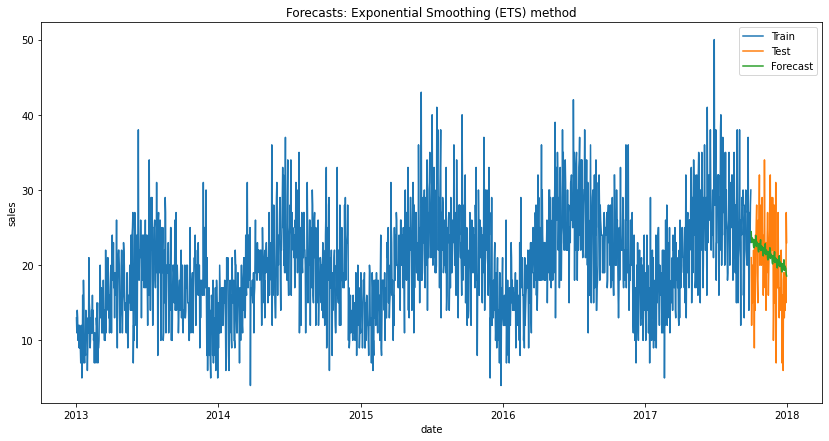

In [26]:
# Evaluate the predictions 
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df['date'], errors_df['pred_sales'], label='Forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts: Exponential Smoothing (ETS) method')
plt.show()

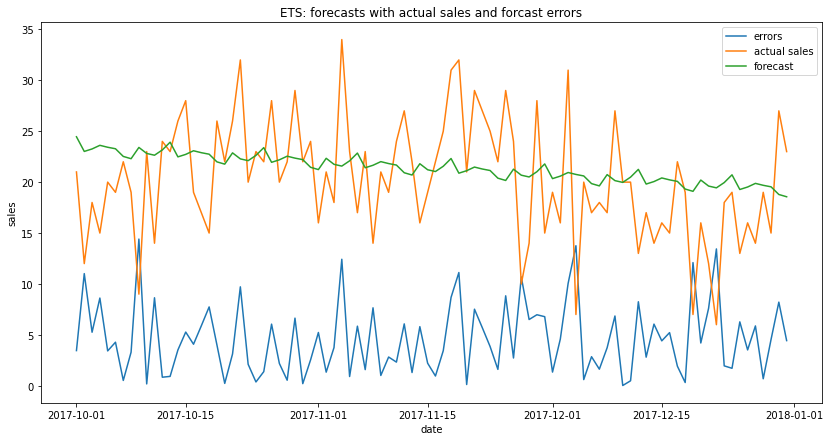

In [29]:
plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('ETS: forecasts with actual sales and forcast errors')
plt.show()